In [2]:
import kaggle
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from keras.models import *
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt

In [3]:
# Importation des jeux de données
train_df = pd.read_csv("certificatbigdata/train.csv",delimiter=",")
test_df = pd.read_csv("certificatbigdata/test.csv",delimiter=",")
store_df = pd.read_csv("certificatbigdata/store_metadata.csv",delimiter=",")

C:\Users\omabe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
train_df

,id,date,customers,open,promo,state_holliday,school_holiday,y
0,1042,2013-01-01,0,0,0,a,1,0
1,128,2013-01-01,0,0,0,a,1,0
2,420,2013-01-01,0,0,0,a,1,0
3,225,2013-01-01,0,0,0,a,1,0
4,144,2013-01-01,0,0,0,a,1,0
...,...,...,...,...,...,...,...,...
813762,757,2015-07-31,684,1,1,0,1,9343
813763,796,2015-07-31,769,1,1,0,1,8913
813764,230,2015-07-31,1091,1,1,0,1,10988
813765,387,2015-07-31,1402,1,1,0,1,14533


In [5]:
store_df

,id,store_type,assortment,promo_interval
0,1,c,a,NaN
1,2,a,a,"Jan,Apr,Jul,Oct"
2,3,a,a,"Jan,Apr,Jul,Oct"
3,4,c,c,NaN
4,5,a,a,NaN
...,...,...,...,...
1110,1111,a,a,"Jan,Apr,Jul,Oct"
1111,1112,c,c,NaN
1112,1113,a,c,NaN
1113,1114,a,c,NaN


# DATA CLEANING

In [6]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813767 entries, 0 to 813766
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              813767 non-null  int64 
 1   date            813767 non-null  object
 2   customers       813767 non-null  int64 
 3   open            813767 non-null  int64 
 4   promo           813767 non-null  int64 
 5   state_holliday  813767 non-null  object
 6   school_holiday  813767 non-null  int64 
 7   y               813767 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 49.7+ MB


In [7]:
# On remarque que les données d'entrainement ne contiennent pas de valeurs NaN
train_df.isna().sum()

id                0
date              0
customers         0
open              0
promo             0
state_holliday    0
school_holiday    0
y                 0
dtype: int64

In [8]:
# Supprimer les données dupliquées
train_df = train_df.drop_duplicates()

In [9]:
print(f"unique open values :{train_df['open'].unique()}")
print(f"unique promo values :{train_df['promo'].unique()}")
print(f"unique state_holliday values :{train_df['state_holliday'].unique()}")
print(f"unique school_holiday values :{train_df['school_holiday'].unique()}")

unique open values :[0 1]
unique promo values :[0 1]
unique state_holliday values :['a' '0' 'b' 'c' 0]
unique school_holiday values :[1 0]


### state_holliday

In [10]:
# Observer les valeurs possibles de state_holliday
train_df['state_holliday'].value_counts()

0    761641
0     27335
a     16201
b      5322
c      3268
Name: state_holliday, dtype: int64

In [11]:
# Puisque state_holiday est binaire, on considère '0' , 0 => 0 et 'a','b','c' => 1
train_df['state_holliday'] = train_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)
test_df['state_holliday'] = test_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)

In [12]:
train_df['state_holliday'].value_counts()

0    788976
1     24791
Name: state_holliday, dtype: int64

### Open Var

In [13]:
# Voir si on dispose dans la base de données un magasin ouvert avec un volume des ventes positif
train_df[(train_df['open']==0) & (train_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [14]:
# Volume de ventes est toujours positif
train_df['y'].min()

0

In [15]:
test_df[(test_df['open']==0) & (test_df['y']>0)]

,id,date,customers,open,promo,state_holliday,school_holiday,y


In [16]:
test_df['y'].min()

0

In [17]:
# On déduit qu'on pourra nous en passer de l'input 'open' car quand ce n'est pas open la valeur y est nulle

#train_df = train_df.drop(columns=['open'])
#test_df = test_df.drop(columns=['open'])

In [18]:
# Vérifier si la variable Date ne prends pas des valeurs abérrantes

def chack_date(date):
  L = date.split('-')
  return len(L)==3 and len(L[0])==4 and len(L[1])==2 and len(L[2])==2
train_df['date'].apply(chack_date).value_counts()

True    813767
Name: date, dtype: int64

In [19]:
import seaborn as sns

<AxesSubplot:>

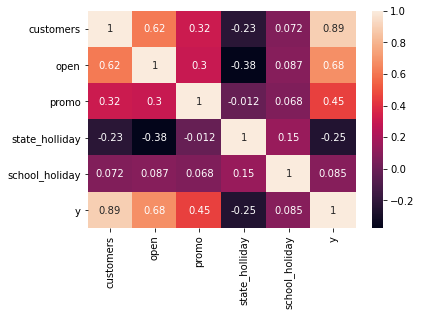

In [20]:
# Corrélation entre la variables; on remarque que le nombre de clients a une grande influence sur la nombre de ventes

sns.heatmap(train_df.drop(columns=['id']).corr(), annot=True)

In [21]:
# On remarque aussi qu'il y a une corrélation linéaire entre 'customers' et 'y'

#pd.plotting.scatter_matrix(train_df.drop(columns=['id','date']).sample(50000), alpha=0.2, figsize=(15,15))

#Feature Eng

In [22]:
display(train_df.head())
display(store_df.head())

,id,date,customers,open,promo,state_holliday,school_holiday,y
0,1042,2013-01-01,0,0,0,1,1,0
1,128,2013-01-01,0,0,0,1,1,0
2,420,2013-01-01,0,0,0,1,1,0
3,225,2013-01-01,0,0,0,1,1,0
4,144,2013-01-01,0,0,0,1,1,0


,id,store_type,assortment,promo_interval
0,1,c,a,NaN
1,2,a,a,"Jan,Apr,Jul,Oct"
2,3,a,a,"Jan,Apr,Jul,Oct"
3,4,c,c,NaN
4,5,a,a,NaN


In [23]:
# Les valeurs possibles de 'store_type'

store_df['store_type'].value_counts()

a    602
d    348
c    148
b     17
Name: store_type, dtype: int64

In [24]:
# Les valeurs possibles de 'assortment'

store_df['assortment'].value_counts()

a    593
c    513
b      9
Name: assortment, dtype: int64

In [25]:
# Les valeurs possibles de 'promo_interval'

store_df['promo_interval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: promo_interval, dtype: int64

In [26]:
train_df['promo'].value_counts()

0    503121
1    310646
Name: promo, dtype: int64

### One hot encoding

In [27]:
# Merger les jeux de données train_df et store_df selon l'id en donnant des valeurs binaires pour chaque type de magasin...

train_df_merged = train_df
test_df_merged = test_df
for col in ['store_type', 'assortment', 'promo_interval']:
    df1 = pd.get_dummies(store_df[col], prefix=col[:5])
    df1['id'] = store_df['id']
    train_df_merged = train_df_merged.join(df1.set_index('id'), on='id')
    test_df_merged = test_df_merged.join(df1.set_index('id'), on='id')

train_df_merged


,id,date,customers,open,promo,state_holliday,school_holiday,y,store_a,store_b,store_c,store_d,assor_a,assor_b,assor_c,"promo_Feb,May,Aug,Nov","promo_Jan,Apr,Jul,Oct","promo_Mar,Jun,Sept,Dec"
0,1042,2013-01-01,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0
1,128,2013-01-01,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0
2,420,2013-01-01,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0
3,225,2013-01-01,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0
4,144,2013-01-01,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813762,757,2015-07-31,684,1,1,0,1,9343,1,0,0,0,0,0,1,0,0,0
813763,796,2015-07-31,769,1,1,0,1,8913,1,0,0,0,0,0,1,0,0,0
813764,230,2015-07-31,1091,1,1,0,1,10988,0,0,0,1,0,0,1,0,0,0
813765,387,2015-07-31,1402,1,1,0,1,14533,0,0,1,0,1,0,0,0,0,1


In [28]:
#Day of week
train_df_merged['day_of_week'] = pd.to_datetime(train_df['date']).dt.dayofweek
test_df_merged['day_of_week'] = pd.to_datetime(train_df['date']).dt.dayofweek

#Day of year
train_df_merged['day_of_year'] = pd.to_datetime(train_df['date']).dt.dayofyear
test_df_merged['day_of_year'] = pd.to_datetime(train_df['date']).dt.dayofyear

display(train_df_merged)

,id,date,customers,open,promo,state_holliday,school_holiday,y,store_a,store_b,store_c,store_d,assor_a,assor_b,assor_c,"promo_Feb,May,Aug,Nov","promo_Jan,Apr,Jul,Oct","promo_Mar,Jun,Sept,Dec",day_of_week,day_of_year
0,1042,2013-01-01,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,1,1
1,128,2013-01-01,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1
2,420,2013-01-01,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1
3,225,2013-01-01,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,1,1
4,144,2013-01-01,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813762,757,2015-07-31,684,1,1,0,1,9343,1,0,0,0,0,0,1,0,0,0,4,212
813763,796,2015-07-31,769,1,1,0,1,8913,1,0,0,0,0,0,1,0,0,0,4,212
813764,230,2015-07-31,1091,1,1,0,1,10988,0,0,0,1,0,0,1,0,0,0,4,212
813765,387,2015-07-31,1402,1,1,0,1,14533,0,0,1,0,1,0,0,0,0,1,4,212


In [29]:
stats_sells = train_df_merged.groupby(['id'])['y'].agg(['mean','max','min','std']).copy()
okay = train_df_merged.groupby(['id','day_of_week'])['y'].agg(['mean','max','min','std']).copy()
display(okay)
train_df_merged = pd.merge(left = train_df_merged , right = stats_sells.reset_index(), on='id', how ='left')
#train_df_merged = pd.merge(left = train_df_merged , right = okay.reset_index(), on=['id','day_of_week'], how ='left')

train_df_merged


mean    max   min          std
id   day_of_week                                       
1    0            5044.972477   9528     0  1596.097448
     1            4677.137931   7959  2362  1021.013741
     2            4409.008929   7821     0  1146.823160
     3            4038.603960   7785     0  1541.612864
     4            4500.756757   8414     0  1410.913393
...                       ...    ...   ...          ...
1115 2            5636.920792   9571     0  1674.879761
     3            5438.931373  11033     0  2161.930322
     4            6175.936364  11673     0  2157.608025
     5            6724.768519  10898  4497  1242.714639
     6               0.000000      0     0     0.000000

[7805 rows x 4 columns]

,id,date,customers,open,promo,state_holliday,school_holiday,y,store_a,store_b,...,assor_c,"promo_Feb,May,Aug,Nov","promo_Jan,Apr,Jul,Oct","promo_Mar,Jun,Sept,Dec",day_of_week,day_of_year,mean,max,min,std
0,1042,2013-01-01,0,0,0,1,1,0,1,0,...,0,1,0,0,1,1,3363.957839,8847,0,1914.783028
1,128,2013-01-01,0,0,0,1,1,0,0,0,...,1,0,1,0,1,1,6176.957143,17309,0,3385.563209
2,420,2013-01-01,0,0,0,1,1,0,0,0,...,1,0,1,0,1,1,3769.974832,9974,0,2007.814341
3,225,2013-01-01,0,0,0,1,1,0,0,0,...,0,0,0,0,1,1,4367.282993,12058,0,2346.796836
4,144,2013-01-01,0,0,0,1,1,0,1,0,...,1,0,0,0,1,1,6343.254576,20637,0,3407.912621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813762,757,2015-07-31,684,1,1,0,1,9343,1,0,...,1,0,0,0,4,212,5095.916777,12188,0,2811.066938
813763,796,2015-07-31,769,1,1,0,1,8913,1,0,...,1,0,0,0,4,212,5960.280702,15608,0,3406.763449
813764,230,2015-07-31,1091,1,1,0,1,10988,0,0,...,1,0,0,0,4,212,6305.500666,14417,0,3219.088937
813765,387,2015-07-31,1402,1,1,0,1,14533,0,0,...,0,0,0,1,4,212,7561.992011,22394,0,4492.261324


In [30]:
#Supprimer la colonne Date 
train_df_new = train_df_merged.drop(columns=['date'])
test_df_new = test_df_merged.drop(columns=['date'])

In [31]:
features = ['mean','max','min','std']
test_df_new = pd.merge(left = test_df_new, right = stats_sells[features],on='id', how ='left')

test_df_new

,id,customers,open,promo,state_holliday,school_holiday,y,store_a,store_b,store_c,...,assor_c,"promo_Feb,May,Aug,Nov","promo_Jan,Apr,Jul,Oct","promo_Mar,Jun,Sept,Dec",day_of_week,day_of_year,mean,max,min,std
0,1105,0,0,0,1,1,0,0,0,1,...,1,1,0,0,1,1,3743.856011,11346,0,2226.381250
1,306,0,0,0,1,1,0,1,0,0,...,0,0,1,0,1,1,3594.572864,7904,0,1935.539194
2,1115,0,0,0,1,1,0,0,0,0,...,1,0,0,1,1,1,5191.963514,12214,0,2831.568639
3,506,0,0,0,1,1,0,1,0,0,...,0,1,0,0,1,1,6202.934871,16837,0,3449.499294
4,877,0,0,0,1,1,0,1,0,0,...,1,0,0,0,1,1,5445.226391,14581,0,2622.869733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203437,728,542,1,1,0,1,0,0,0,0,...,0,0,1,0,5,229,4345.749674,11379,0,2243.274237
203438,323,716,1,1,0,1,0,0,0,0,...,1,1,0,0,5,229,6127.597333,17828,0,3154.009470
203439,912,806,1,1,0,1,0,0,0,1,...,1,0,0,0,5,229,4786.674113,13489,0,2507.705510
203440,276,575,1,1,0,1,0,1,0,0,...,0,0,0,1,5,229,3489.566013,8771,0,1870.515531


In [32]:
train_nozero = train_df_new[train_df_new['customers']>0]
train_group = train_nozero.groupby(['id','day_of_week'])

ratio_df = pd.DataFrame({'ratio':train_group['y'].sum()/train_group['customers'].sum()})

train_group_m = pd.merge(left = train_nozero, right = ratio_df ,on=['id','day_of_week'], how ='left')
test_df_new1 = pd.merge(left = test_df_new, right = ratio_df,on=['id','day_of_week'], how ='left')
test_df_new1

,id,customers,open,promo,state_holliday,school_holiday,y,store_a,store_b,store_c,...,"promo_Feb,May,Aug,Nov","promo_Jan,Apr,Jul,Oct","promo_Mar,Jun,Sept,Dec",day_of_week,day_of_year,mean,max,min,std,ratio
0,1105,0,0,0,1,1,0,0,0,1,...,1,0,0,1,1,3743.856011,11346,0,2226.381250,8.886458
1,306,0,0,0,1,1,0,1,0,0,...,0,1,0,1,1,3594.572864,7904,0,1935.539194,9.355798
2,1115,0,0,0,1,1,0,0,0,0,...,0,0,1,1,1,5191.963514,12214,0,2831.568639,14.573775
3,506,0,0,0,1,1,0,1,0,0,...,1,0,0,1,1,6202.934871,16837,0,3449.499294,9.022218
4,877,0,0,0,1,1,0,1,0,0,...,0,0,0,1,1,5445.226391,14581,0,2622.869733,7.372790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203437,728,542,1,1,0,1,0,0,0,0,...,0,1,0,5,229,4345.749674,11379,0,2243.274237,11.342597
203438,323,716,1,1,0,1,0,0,0,0,...,1,0,0,5,229,6127.597333,17828,0,3154.009470,11.387933
203439,912,806,1,1,0,1,0,0,0,1,...,0,0,0,5,229,4786.674113,13489,0,2507.705510,7.510376
203440,276,575,1,1,0,1,0,1,0,0,...,0,0,1,5,229,3489.566013,8771,0,1870.515531,7.955245


In [33]:
train_group_na = train_nozero.groupby(['id'])
ratio_df_na = pd.DataFrame({'ratio':train_group_na['y'].sum()/train_group_na['customers'].sum()})
test_df_new1['ratio'] = test_df_new1.apply(lambda x: ratio_df_na.loc[x['id']] if x['ratio'] != x['ratio'] else x['ratio'], axis=1)


In [34]:
train_group_m['app_y'] = train_group_m['customers']*train_group_m['ratio']
test_df_new1['app_y'] = test_df_new1['customers']*test_df_new1['ratio']

In [35]:
test_df_new = test_df_new1
train_df_new = train_group_m

In [36]:
# Vérifier si train_df_new ne contient au final que des valeurs numériques

train_df_new.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

id                        True
customers                 True
open                      True
promo                     True
state_holliday            True
school_holiday            True
y                         True
store_a                   True
store_b                   True
store_c                   True
store_d                   True
assor_a                   True
assor_b                   True
assor_c                   True
promo_Feb,May,Aug,Nov     True
promo_Jan,Apr,Jul,Oct     True
promo_Mar,Jun,Sept,Dec    True
day_of_week               True
day_of_year               True
mean                      True
max                       True
min                       True
std                       True
ratio                     True
app_y                     True
dtype: bool

<AxesSubplot:>

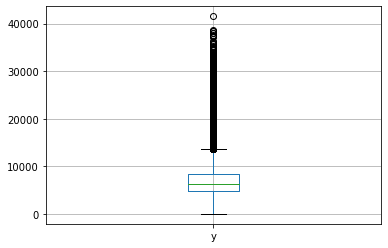

In [37]:
#train_df_new['ratio'] = 

train_df_new.boxplot(column = ['y'])

# Process and Prepare Data

In [38]:
# Separating the features and the target
X , y = train_df_new.drop(columns=['id','y']), train_df_new['y']

# Print input/target format 
print(f'Input shape  : {X.shape}')
print(f'Target shape : {y.shape}')
display(X)

Input shape  : (675506, 23)
Target shape : (675506,)


,customers,open,promo,state_holliday,school_holiday,store_a,store_b,store_c,store_d,assor_a,...,"promo_Jan,Apr,Jul,Oct","promo_Mar,Jun,Sept,Dec",day_of_week,day_of_year,mean,max,min,std,ratio,app_y
0,729,1,0,1,1,0,1,0,0,0,...,1,0,1,1,4050.715395,9466,0,1470.084467,3.942159,2873.834044
1,482,1,0,1,1,0,1,0,0,1,...,1,0,1,1,13248.323760,31406,2401,4837.920783,5.699577,2747.196042
2,1248,1,0,1,1,0,1,0,0,0,...,1,0,1,1,10842.939073,18177,5035,1841.801859,3.358659,4191.606048
3,619,1,0,1,1,0,1,0,0,1,...,0,0,1,1,7335.465426,15386,3215,2304.071961,7.255020,4490.857124
4,777,1,0,1,1,0,1,0,0,0,...,0,0,1,1,7489.412483,17630,0,2653.663393,4.256071,3306.966963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675501,684,1,1,0,1,1,0,0,0,0,...,0,0,4,212,5095.916777,12188,0,2811.066938,11.625640,7951.937919
675502,769,1,1,0,1,1,0,0,0,0,...,0,0,4,212,5960.280702,15608,0,3406.763449,10.584014,8139.106862
675503,1091,1,1,0,1,0,0,0,1,0,...,0,0,4,212,6305.500666,14417,0,3219.088937,8.097225,8834.072720
675504,1402,1,1,0,1,0,0,1,0,1,...,0,1,4,212,7561.992011,22394,0,4492.261324,7.753565,10870.498006


In [39]:
# Split to train and test 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardizing the features
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
#X_test = scaler.transform(test_df_new.drop(columns=['id','y']))

#power = PowerTransformer(method='yeo-johnson', standardize=True)
#X_train = power.fit_transform(X_train)
#X_valid = power.transform(X_valid)
#X_test = power.transform(test_df_new.drop(columns=['id','y']))

X_train= X_train.to_numpy()
X_valid= X_valid.to_numpy()
y_train= y_train.to_numpy()
y_valid= y_valid.to_numpy()


# Print Data size
print(f'Train size : {X_train.shape[0]}')
print(f'Validation size : {X_valid.shape[0]}')
#print(f'Test size : {X_test.shape[0]}')

Train size : 540404
Validation size : 135102


# Train Models Pipeline

In [40]:
Models = dict()

In [41]:
def train_model_grid_search(model_name, model, grid, train_data=(X_train,y_train), valid_data=(X_valid,y_valid),
                            eval_metric='neg_mean_absolute_error', save_dict=Models, verbose=1):
    """
    model_name : Name of the model
    model : sklearn model
    grid : Hyper parameters search grid
    train_data : (train inputs, train outputs)
    eval_metric : evaluation metric in the grid search
    ------------------
    Trains model on training data using a grid search and cross validation then saves trained model in save_dict
    """
    model_cv = GridSearchCV(model, grid, scoring=eval_metric, cv=5)
    model_cv.fit(X_train, y_train)
    train_preds, valid_preds = model_cv.predict(X_train) , model_cv.predict(X_valid)
    #train_preds, valid_preds = np.maximum(train_preds,0) , np.maximum(valid_preds,0)
    save_dict[model_name] = {'model':model_cv,
                             'scores':{'train': mae(y_train, train_preds),
                                       'valid' :mae(y_valid, valid_preds)
                                       }}
    if verbose ==1:
        print(f" -  {model_name} best hyperparameters : {model_cv.best_params_}",'\n\n')
        print(f" -  {model_name} results on the train set:" )
        print(mae(y_train, train_preds))
        print(f" -  {model_name} results on the valid set:")
        print(mae(y_valid, valid_preds))
        

### Linear Regression

In [170]:
train_model_grid_search(model_name = 'Linear Regression',
                        model = LinearRegression(),
                        grid = {'fit_intercept':[True,False], 
                                'copy_X':[True, False],
                                'normalize':[True,False]})

 -  Linear Regression best hyperparameters : {'copy_X': True, 'fit_intercept': False, 'normalize': True} 


 -  Linear Regression results on the train set:
389.1525368738844
 -  Linear Regression results on the valid set:
391.2462114988893


### Decision trees


In [160]:
train_model_grid_search(model_name = 'Decision Tree Regression',
                        model = DecisionTreeRegressor(random_state = 42),
                        grid = {'max_depth':list(range(5,20,4)),'min_samples_leaf':range(1,10,2)
                                })

 -  Decision Tree Regression best hyperparameters : {'max_depth': 13, 'min_samples_leaf': 9} 


 -  Decision Tree Regression results on the train set:
306.3625566067996
 -  Decision Tree Regression results on the valid set:
327.17412231903717


### Random Forest

In [ ]:
train_model_grid_search(model_name = 'Random Forest Regression',
                        model = RandomForestRegressor(min_samples_split=2, random_state = 42), 
                        grid = {'max_depth': range(10,100,30),
                                'min_samples_leaf':range(2,10,3),
                                'n_estimators': [100, 200, 300]}
                        )

### K-NN

In [ ]:
train_model_grid_search(model_name = 'K-NN',
                        model = KNeighborsRegressor(),
                        grid = {#'n_neighbors':range(1,7),
                                #'weights':['uniform','distance'],
                                })

### XGBoost

In [1]:
train_model_grid_search(model_name = 'XGBoost',
                        model = XGBRegressor(),
                        grid = {'max_depth': [3, 4, 5, 6, 7]})

NameError: name 'train_model_grid_search' is not defined

### SVM

In [ ]:
train_model_grid_search(model_name = 'SVM',
                        model = SVR(),
                        grid = {#'C':[0.01, 1, 10],
#                                 'gamma':[0.001, 0.01, 0.1, 1],
                                'kernel':['linear']})

### Neural Network

In [142]:
# Separating the features and the target
X, y = train_df_new.drop(columns=['y', 'id']), train_df_new['y']

# Standardizing the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Print input/target format 
print(f'Input shape  : {X.shape}')
print(f'Target shape : {y.shape}\n')
print(f'Target : \n{y}')

Input shape  : (813767, 17)
Target shape : (813767,)

Target : 
0             0
1             0
2             0
3             0
4             0
          ...  
813762     9343
813763     8913
813764    10988
813765    14533
813766     8941
Name: y, Length: 813767, dtype: int64


In [143]:
# Split to train and test 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = scaler.transform(test_df_new.drop(columns=['y', 'id']))

# Print Data size
print(f'Train size : {X_train.shape[0]}')
print(f'Validation size : {X_valid.shape[0]}')
print(f'Test size : {X_test.shape[0]}')

Train size : 651013
Validation size : 162754
Test size : 203442


In [144]:
# create model
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], activation='softplus'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='softplus'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='softplus'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
# Compile model
model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0001), metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                576       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

In [145]:
# Training params
nb_epochs = 50
model_hist = model.fit(x=X_train, y=y_train, validation_data=(X_valid,y_valid), batch_size=32, epochs=nb_epochs, verbose=1).history

Epoch 1/50
20345/20345 [==============================] - 74s 4ms/step - loss: 2376.1564 - mean_absolute_error: 2376.1564 - val_loss: 885.9729 - val_mean_absolute_error: 885.9729
Epoch 2/50
20345/20345 [==============================] - 77s 4ms/step - loss: 1344.1995 - mean_absolute_error: 1344.1995 - val_loss: 809.8192 - val_mean_absolute_error: 809.8192
Epoch 3/50
20345/20345 [==============================] - 80s 4ms/step - loss: 1290.5656 - mean_absolute_error: 1290.5656 - val_loss: 805.1924 - val_mean_absolute_error: 805.1924
Epoch 4/50
20345/20345 [==============================] - 81s 4ms/step - loss: 1273.0626 - mean_absolute_error: 1273.0626 - val_loss: 792.6286 - val_mean_absolute_error: 792.6286
Epoch 5/50
20345/20345 [==============================] - 78s 4ms/step - loss: 1268.1528 - mean_absolute_error: 1268.1528 - val_loss: 798.6401 - val_mean_absolute_error: 798.6401
Epoch 6/50
20345/20345 [==============================] - 81s 4ms/step - loss: 1262.0179 - mean_absolute_

In [153]:
##Prediction
train_preds = model.predict(X_train)
valid_preds = model.predict(X_valid)
Models['Neural Network'] = {'model':model,
                             'scores':{'train':mae(y_train, train_preds),
                                       'valid' :mae(y_valid, valid_preds)}}
print("   -   MAE on the train set : {:.2f}".format(Models['Neural Network']['scores']['train']))
print("   -   MAE on the test set : {:.2f}".format(Models['Neural Network']['scores']['valid']))

   -   MAE on the train set : 767.65
   -   MAE on the test set : 763.41


# Approch Results

<AxesSubplot:>

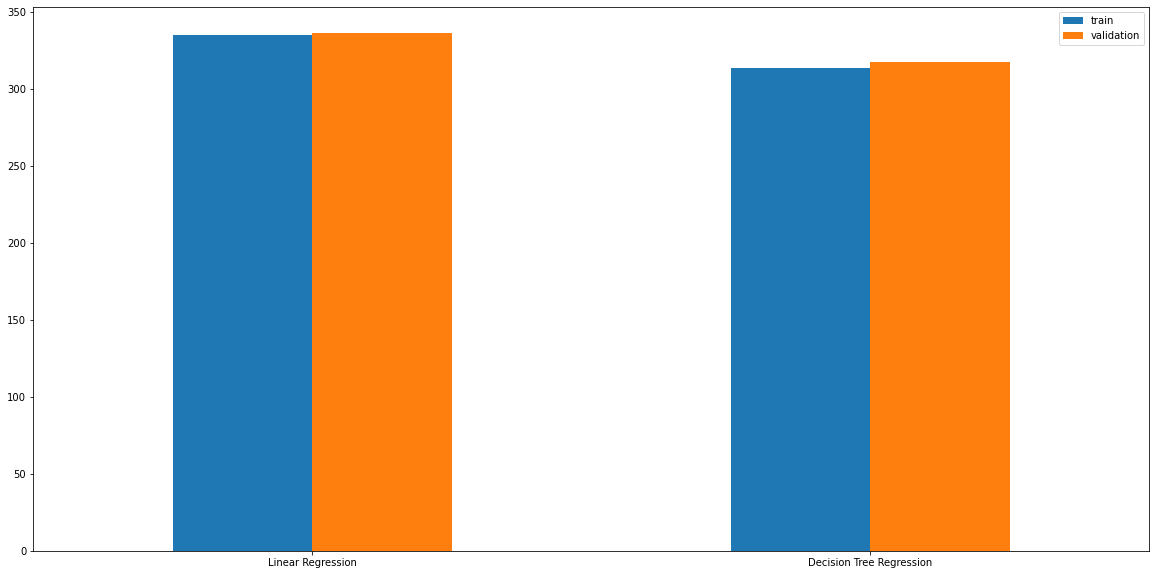

In [49]:
df_results_1 = pd.DataFrame([[model['scores']['train'],model['scores']['valid']] for model_name,model in Models.items()],
                           columns=['train', 'validation'],
                           index=list(Models.keys()))

df_results_1.plot.bar(rot=0, figsize=(20,10))

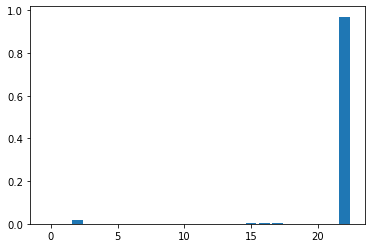

In [161]:
# visualize feature importance scores 
model = Models['Decision Tree Regression']['model'].best_estimator_
importance = model.feature_importances_
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## BEST MODEL - trained on both train and valid set

In [162]:
#best_model = DecisionTreeRegressor(max_depth= 9, min_samples_leaf= 4)
best_model = DecisionTreeRegressor(random_state = 42, **Models['Decision Tree Regression']['model'].best_params_)
#best_model = XGBRegressor(max_depth=5)
#best_model = SVR(kernel='linear')

In [163]:
# X désigne X_train et X_valid concaténé

#Scaling
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#X_test = scaler.transform(test_df_new.drop(columns=['id','y']))

#Power
#power = PowerTransformer(method='yeo-johnson', standardize=True)
#X = power.fit_transform(X) 
#X_test = power.transform(test_df_new.drop(columns=['id','y']))

X_test = test_df_new.drop(columns=['id','y'])
X_test

,customers,open,promo,state_holliday,school_holiday,store_a,store_b,store_c,store_d,assor_a,...,"promo_Jan,Apr,Jul,Oct","promo_Mar,Jun,Sept,Dec",day_of_week,day_of_year,mean,max,min,std,ratio,app_y
0,0,0,0,1,1,0,0,1,0,0,...,0,0,1,1,3743.856011,11346,0,2226.381250,8.88646,0
1,0,0,0,1,1,1,0,0,0,1,...,1,0,1,1,3594.572864,7904,0,1935.539194,9.3558,0
2,0,0,0,1,1,0,0,0,1,0,...,0,1,1,1,5191.963514,12214,0,2831.568639,14.5738,0
3,0,0,0,1,1,1,0,0,0,1,...,0,0,1,1,6202.934871,16837,0,3449.499294,9.02222,0
4,0,0,0,1,1,1,0,0,0,0,...,0,0,1,1,5445.226391,14581,0,2622.869733,7.37279,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203437,542,1,1,0,1,0,0,0,1,1,...,1,0,5,229,4345.749674,11379,0,2243.274237,11.3426,6147.69
203438,716,1,1,0,1,0,0,0,1,0,...,0,0,5,229,6127.597333,17828,0,3154.009470,11.3879,8153.76
203439,806,1,1,0,1,0,0,1,0,0,...,0,0,5,229,4786.674113,13489,0,2507.705510,7.51038,6053.36
203440,575,1,1,0,1,1,0,0,0,1,...,0,1,5,229,3489.566013,8771,0,1870.515531,7.95525,4574.27


In [164]:
#Entrainement
best_model.fit(X,y)

DecisionTreeRegressor(max_depth=13, min_samples_leaf=9, random_state=42)

In [165]:
test_preds = X_test.apply(lambda x: 0 if x['customers']==0 else best_model.predict(np.array([x.to_numpy()]))[0], axis = 1)
#X_test[:500].apply(lambda x: 0 if x['customers']==0 else best_model.predict(np.array([x.to_numpy()]))[0], axis = 1)

#Prediction
#test_preds = best_model.predict(X_test)
test_preds

0            0.000000
1            0.000000
2            0.000000
3            0.000000
4            0.000000
             ...     
203437    6380.750000
203438    8214.800937
203439    6058.638596
203440    4651.746328
203441    6227.177570
Length: 203442, dtype: float64

In [166]:
#MAE
mae(y, best_model.predict(X))

307.61529315456244

In [169]:
X

,customers,open,promo,state_holliday,school_holiday,store_a,store_b,store_c,store_d,assor_a,...,"promo_Jan,Apr,Jul,Oct","promo_Mar,Jun,Sept,Dec",day_of_week,day_of_year,mean,max,min,std,ratio,app_y
0,729,1,0,1,1,0,1,0,0,0,...,1,0,1,1,4050.715395,9466,0,1470.084467,3.942159,2873.834044
1,482,1,0,1,1,0,1,0,0,1,...,1,0,1,1,13248.323760,31406,2401,4837.920783,5.699577,2747.196042
2,1248,1,0,1,1,0,1,0,0,0,...,1,0,1,1,10842.939073,18177,5035,1841.801859,3.358659,4191.606048
3,619,1,0,1,1,0,1,0,0,1,...,0,0,1,1,7335.465426,15386,3215,2304.071961,7.255020,4490.857124
4,777,1,0,1,1,0,1,0,0,0,...,0,0,1,1,7489.412483,17630,0,2653.663393,4.256071,3306.966963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675501,684,1,1,0,1,1,0,0,0,0,...,0,0,4,212,5095.916777,12188,0,2811.066938,11.625640,7951.937919
675502,769,1,1,0,1,1,0,0,0,0,...,0,0,4,212,5960.280702,15608,0,3406.763449,10.584014,8139.106862
675503,1091,1,1,0,1,0,0,0,1,0,...,0,0,4,212,6305.500666,14417,0,3219.088937,8.097225,8834.072720
675504,1402,1,1,0,1,0,0,1,0,1,...,0,1,4,212,7561.992011,22394,0,4492.261324,7.753565,10870.498006


## Save as .csv

In [167]:
d = {'y': test_preds}
result = pd.DataFrame(data=d)
result.index.names = ['index']
result

,y
index,
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
203437,6380.750000
203438,8214.800937
203439,6058.638596


In [168]:
result.to_csv('solution.csv',encoding='ISO-8859-1', sep=',')